# Convolutional Neural Network using Sentinel 2 for the classification of landcover within South Dakota

This notebooknotebook sits alongside the masters thesis for Andrew Holden submitted as part of his stuidies towards a Masters in Geographical Information Management at Cranfield University. 


## Configure the Environment

In [1]:
import ee
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import display, Image
from functools import reduce
import h5py
import seaborn as sns
from ee_datasets import ee_datasets
import seaborn as sns
import sklearn
from sklearn.model_selection import train_test_split

Using TensorFlow backend.
/usr/local/lib/python3.5/dist-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.5/dist-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.5/dist-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.5/dist-packages/tensorflow/python/framework/dtypes.py:519: FutureWarn

In [2]:
ee.Initialize()

## Parameters to set a the start

In [3]:
# epochs
epc = 10
# land cover categories
cls = 8
#batch size
bth = 32
#number of bands 
bnd = 6
#number of nodes/neurons
node = 1028
node2 = 1028

# Start and stop of time series
startDate = ee.Date('2016-08-01')
stopDate  = ee.Date('2016-08-11')

#CDL dates
startDateCrop = ee.Date('2016-01-01')
stopDateCrop  = ee.Date('2016-12-31')

#chart titles
titles = ['Corn', 'Soy', 'Urban', 'Alfalfa','Other Hay','Water','Grass','Other']
labels = ['Corn', 'Soy', 'Urban', 'Alfalfa','Other Hay','Water','Grass','Other']
titlesx=['Blue', 'Green', 'Red', 'NIR', 'NDVI', 'NDWI']

# Central position of (AOIs) - both containing a large amount of corn and soybean acres
points = [[-96.8389, 44.43378], [-97.580566, 43.678301]]

# Central position of (AOIs) - one hay and one corn/beans
#points = [[-102.5463, 44.6842], [-97.580566, 43.678301]]

#one study area - i.e. instead of the usual 2 scenarios
points1 = [-97.580566, 43.678301]

# Central position of (AOIs) - Dell Rapids - South Dakota
point2 = [-96.61651, 43.933506]

# Central position of (AOIs) - Pierre - South Dakota
#points2 = [-100.362854, 44.371314]

**Functions**

In [4]:
def display_image(image, region, Vizz = None):
    """
    Displays images in notebook
    """ 
    ## Visualization
    if Vizz:
        image = image.visualize(**Vizz)
        
    visual = Image(url=image.getThumbUrl({
                'region':region
                }))
    
    display(visual)

In [5]:
def CloudMaskS2(image):
    """
    European Space Agency (ESA) clouds from 'QA60', i.e. Quality Assessment band at 60m
    parsed by Nick Clinton
    """
    qa = image.select('QA60')

    # Bits 10 and 11 are clouds and cirrus, respectively.
    cloudBitMask = int(2**10)
    cirrusBitMask = int(2**11)

    # Both flags set to zero indicates clear conditions.
    mask = qa.bitwiseAnd(cloudBitMask).eq(0).And(\
            qa.bitwiseAnd(cirrusBitMask).eq(0))

    return image.updateMask(mask).divide(10000)

In [6]:
def CloudFreeCompositeS2(Collection_id, startDate, stopDate, geom):
    ## Define your collection
    collection = ee.ImageCollection(Collection_id)

    ## Filter 
    collection = collection.filterBounds(geom).filterDate(startDate,stopDate)\
            .filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE', 20))\
            .map(CloudMaskS2)

    ## Composite
    composite = collection.median()
    
    return composite

## Sentinel 2  
### Sentinel-2 MSI: MultiSpectral Instrument, Level-1C ([gee](https://developers.google.com/earth-engine/datasets/catalog/COPERNICUS_S2))
**Dataset Availability**: 2015-06-23T00:00:00 - Present

**Wavebands**

|Band 	|Use 		|Wavelength (nm) |Resolution (m)|
|-------|-----------|----------------|--------------|
|B1 	|Aerosols 	|443 	|60|
|B2 	|Blue 		|490 	|10|
|B3 	|Green 		|560 	|10|
|B4 	|Red 		|665 	|10|
|B6 	|Red Edge 2 |740 	|20|
|B8 	|NIR        |835 	|10|
|B8a 	|Red Edge 4 |865 	|20|
|B9 	|Water vapor|940 	|60|
|B10 	|Cirrus 	|1375 	|60|
|B11 	|SWIR 1 	|1610 	|20|
|B12 	|SWIR 2 	|2190 	|20|
|QA60   |ESA Cloud  | n/a   |60|

In [7]:
# GEE Image Collection ID
Collection_id = 'COPERNICUS/S2'

# Scale in meters
scale = 10

## Cropland Data Layer
### USDA NASS Cropland Data Layers ([gee](https://developers.google.com/earth-engine/datasets/catalog/USDA_NASS_CDL))

**Dataset Availability**: January 1997 - Present

**Resolution**
30 meters

**Bands**

|Name 	    |Min|Max |Description 	|
|-----------|---|----|--------------|
|cropland 	|1 	|254 |Main crop-specific land cover classification.|
|cultivated |1 	|2   |Classification layer for identifying cultivated and non-cultivated land cover. Available from 2013 to 2017.|
|confidence |0 	|100 |Per-pixel predicted confidence of the given classification, with 0 being the least confident and 100 the most confident.|

In [11]:
# GEE Image Collection ID
Collection_id = 'USDA/NASS/CDL'

In [12]:
Collection_id

'USDA/NASS/CDL'

Ground truth land cover classification

In [13]:
dataset = ee.ImageCollection(Collection_id)\
    .filterBounds(geom)\
    .filterDate(startDate,stopDate)

# First image
image = ee.Image(dataset.first())

# Choose the scale
image =  image.reproject(crs='EPSG:4326', scale=scale)

## Download datasets
We download and stack datasets from two different Areas of Interest (AOIs)

In [14]:
from ee_datasets_cloud import ee_datasets

for n, point in enumerate(points):
    sentinel = ee_datasets(point = point, buffer = 10000 , startDate = startDate, stopDate = stopDate, scale = scale, collection = 'Sentinel2')
    cropland = ee_datasets(point = point, buffer = 10000 , startDate = startDateCrop, stopDate = stopDateCrop, scale = scale, collection = 'CroplandDataLayers')
    dataset_x = sentinel.read_datasets()
    dataset_y = cropland.read_datasets()
    if n == 0:
        data_x = dataset_x
        data_y = dataset_y
    else:
        szy1, szx1 = data_x.shape[:2]
        szy2, szx2 = dataset_x.shape[:2]
        if szy1 != szy2 or szx1 != szx2:
            szy = min(szy1, szy2)
            szx = min(szx1, szx2)
            
            data_x = np.stack((data_x[:szy,:szx,:], dataset_x[:szy,:szx,:]), axis=0)
            data_y = np.stack((data_y[:szy,:szx,:], dataset_y[:szy,:szx,:]), axis=0)
        else:
            data_x = np.stack((data_x, dataset_x), axis=0)
            data_y = np.stack((data_y, dataset_y), axis=0)

## Download the CDL and put into a 2D array

In [15]:
#just cropland data for 1 region to make a specific cropland layer
sentinel = ee_datasets(point = point2, buffer = 10000 , startDate = startDate, stopDate = stopDate, scale = scale, collection = 'Sentinel2')
cropland = ee_datasets(point = points1,buffer = 10000 , startDate = startDateCrop, stopDate = stopDateCrop, scale = scale, collection = 'CroplandDataLayers')
dataset_x2d = sentinel.read_datasets()
dataset_y2d = cropland.read_datasets()

In [16]:
dataset_y1d = dataset_y2d.transpose(2,0,1).reshape(-1,dataset_y2d.shape[1])

**Display channels**

We display the input and output datasets

In [17]:
def display_channels(data, nChannels, titles = False):
    if nChannels == 1:
        plt.figure(figsize=(5,5))
        plt.imshow(data[:,:,0])
        if titles:
            plt.title(titles[0])
    else:
        fig, axs = plt.subplots(nrows=1, ncols=nChannels, figsize=(5*nChannels,5))
        for i in range(nChannels):
            ax = axs[i]
            ax.imshow(data[:,:,i])
            if titles:
                ax.set_title(titles[i])

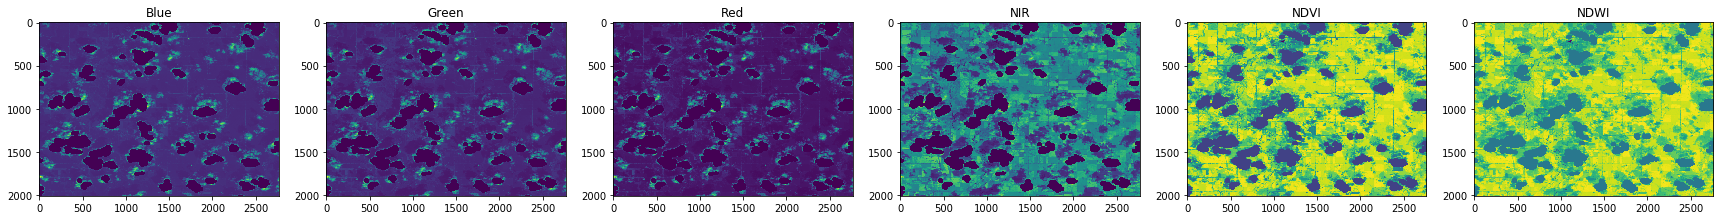

In [18]:
# 1 channel display
display_channels(dataset_x2d, data_x.shape[3], titles=titlesx)

Sentinel 2 composite for the for the fist AOI

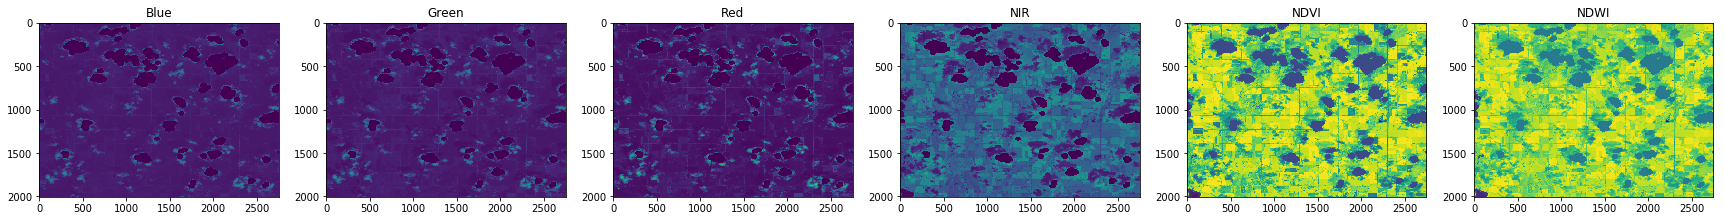

In [19]:
display_channels(data_x[0,:,:,:], data_x.shape[3], titles=titlesx)

Ground truth land cover classification for the for the fist AOI

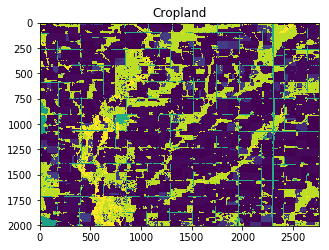

In [20]:
display_channels(data_y[0,:,:,:], data_y.shape[3], titles=['Cropland'])

Sentinel 2 composite for the for the second AOI

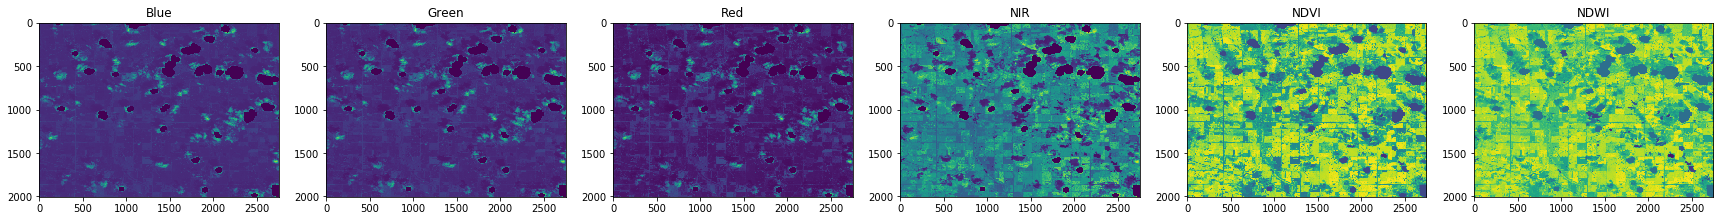

In [21]:
display_channels(data_x[1,:,:,:], data_x.shape[3], titles=titlesx)

Ground truth land cover classification for the for the second AOI

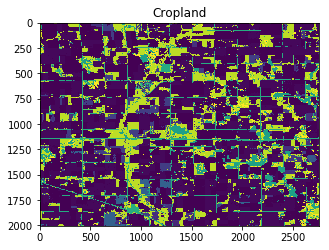

In [22]:
display_channels(data_y[1,:,:,:], data_y.shape[3], titles=['Cropland'])

## Set data y to a 2D array - i.e. all the info in one layer

In [23]:
dataset_y.shape

(2004, 2753, 1)

In [24]:
#seperates out the classes
data_x0 = data_x[0,:,:,:]
data_x1 = data_x[1,:,:,:]
data_y0 = data_y[0,:,:,:]
data_y1 = data_y[1,:,:,:]

## Preprocess class labels

Each class in encoded as a value in the range between 0 to 254. For training a Neural Network in Keras we have to convert the 1-dimensional class arrays to N classes-dimensional matrices. To simplify the problem here we regroup all the classes into 8 categories.

In [25]:
# Area of Interest (AoI)
geom = ee.Geometry.Point(points[0]).buffer(10000)
# Start and stop of time series
# startDate = ee.Date('2016')
# stopDate  = ee.Date('2017')
# Read the ImageCollection
dataset = ee.ImageCollection('USDA/NASS/CDL')\
    .filterBounds(geom)\
    .filterDate(startDateCrop,stopDateCrop)
# Get the cropland class values and names
cropland_info = pd.DataFrame({'cropland_class_values':dataset.getInfo().get('features')[0].get('properties').get('cropland_class_values'),
                              'cropland_class_palette':dataset.getInfo().get('features')[0].get('properties').get('cropland_class_palette'),
                              'cropland_class_names':dataset.getInfo().get('features')[0].get('properties').get('cropland_class_names')
                             })
cropland_info.head()

cropland_class_names cropland_class_palette  cropland_class_values
0           Background                 000000                    0.0
1                 Corn                 ffd300                    1.0
2               Cotton                 ff2626                    2.0
3                 Rice                 00a8e5                    3.0
4              Sorghum                 ff9e0c                    4.0

The number of unique classes in this are is equal to:

In [26]:
len(np.unique(data_y[:,:,:,0]))

28

and the number of pixels by class

In [27]:
value, count = np.unique(data_y[0,:,:,0], return_counts=True)
df = pd.DataFrame({'cropland_class_values': value, 'cropland_class_counts': count})
df.sort_values(by='cropland_class_counts', ascending=False, inplace=True)
df = pd.merge(df, cropland_info, how='left', on=['cropland_class_values'])
df.head()

cropland_class_counts  cropland_class_values  cropland_class_names  \
0                1763951                    1.0                  Corn   
1                1603452                    5.0              Soybeans   
2                1238444                  176.0     Grassland/Pasture   
3                 229862                  121.0  Developed/Open Space   
4                 164594                  195.0   Herbaceous Wetlands   

  cropland_class_palette  
0                 ffd300  
1                 267000  
2                 e8ffbf  
3                 9b9b9b  
4                 7fb2b2

In [28]:
value, count = np.unique(data_y[1,:,:,0], return_counts=True)
df = pd.DataFrame({'cropland_class_values': value, 'cropland_class_counts': count})
df.sort_values(by='cropland_class_counts', ascending=False, inplace=True)
df = pd.merge(df, cropland_info, how='left', on=['cropland_class_values'])
df.head()

cropland_class_counts  cropland_class_values  cropland_class_names  \
0                2013667                    1.0                  Corn   
1                1612165                    5.0              Soybeans   
2                 873435                  176.0     Grassland/Pasture   
3                 246536                  121.0  Developed/Open Space   
4                 229362                  111.0            Open Water   

  cropland_class_palette  
0                 ffd300  
1                 267000  
2                 e8ffbf  
3                 9b9b9b  
4                 4c70a3

In [29]:
# formula to change the class labels
def replace_values(array, class_labels, new_label):
    array_new = np.copy(array)
    for i in range(len(class_labels)):
        array_new[array == class_labels[i]] = new_label
        
    return array_new

## Reprocess the CDL categories into 8 classes

In [30]:
# New classes
corn = ['1']
soy = ['5']
urban = ['121', '122', '123', '124']
alf = ['36']
nonalf = ['37']
water = ['111']
grass = ['176']

#Concatenated list of classes
combined_classes = corn+soy+urban+alf+nonalf+water+grass

class_labels_1 = np.array(cropland_info['cropland_class_values'][cropland_info['cropland_class_values'].isin(corn)])
class_labels_2 = np.array(cropland_info['cropland_class_values'][cropland_info['cropland_class_values'].isin(soy)])
class_labels_3 = np.array(cropland_info['cropland_class_values'][cropland_info['cropland_class_values'].isin(urban)])
class_labels_4 = np.array(cropland_info['cropland_class_values'][cropland_info['cropland_class_values'].isin(alf)])
class_labels_5 = np.array(cropland_info['cropland_class_values'][cropland_info['cropland_class_values'].isin(nonalf)])
class_labels_6 = np.array(cropland_info['cropland_class_values'][cropland_info['cropland_class_values'].isin(water)]) 
class_labels_7 = np.array(cropland_info['cropland_class_values'][cropland_info['cropland_class_values'].isin(grass)]) 
class_labels_8 = np.array(cropland_info['cropland_class_values'][~cropland_info['cropland_class_values'].isin(combined_classes)])

# We replace the class labels - use 1000s to make sure values are not overwritten
new_data_y = np.copy(data_y[:,:,:,0])
new_data_y = replace_values(new_data_y, class_labels_1, 1000.)
new_data_y = replace_values(new_data_y, class_labels_2, 2000.)
new_data_y = replace_values(new_data_y, class_labels_3, 3000.)
new_data_y = replace_values(new_data_y, class_labels_4, 4000.)
new_data_y = replace_values(new_data_y, class_labels_5, 5000.)
new_data_y = replace_values(new_data_y, class_labels_6, 6000.)
new_data_y = replace_values(new_data_y, class_labels_7, 7000.)  
new_data_y = replace_values(new_data_y, class_labels_8, 8000.)

#Divide by 1000 and subtract 1 to get results 0 to 7
new_data_y = np.divide(new_data_y, 1000.) -1

# Convert 1-dimensional class arrays to 4-dimensional class matrices
from keras.utils import np_utils
new_data_y = np_utils.to_categorical(new_data_y, cls)


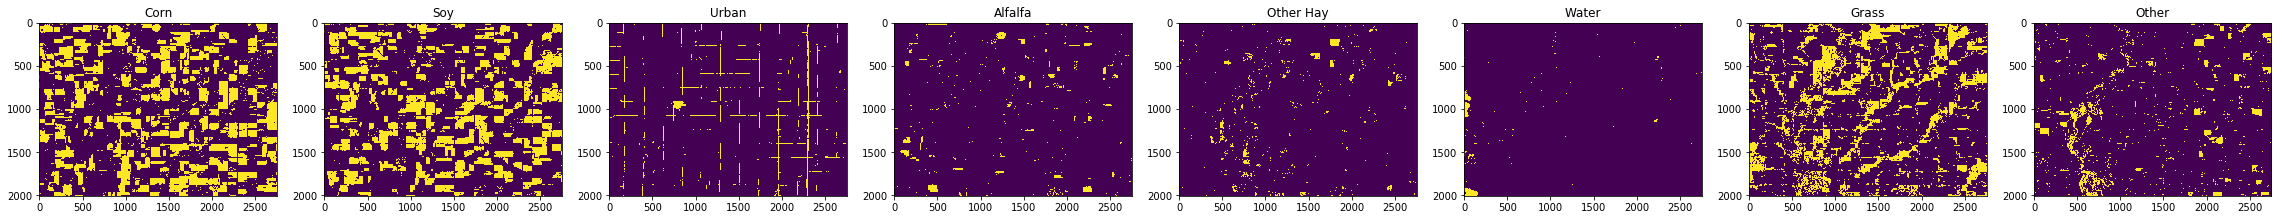

In [31]:
display_channels(new_data_y[0,:,:,:], new_data_y.shape[3], titles=titles)

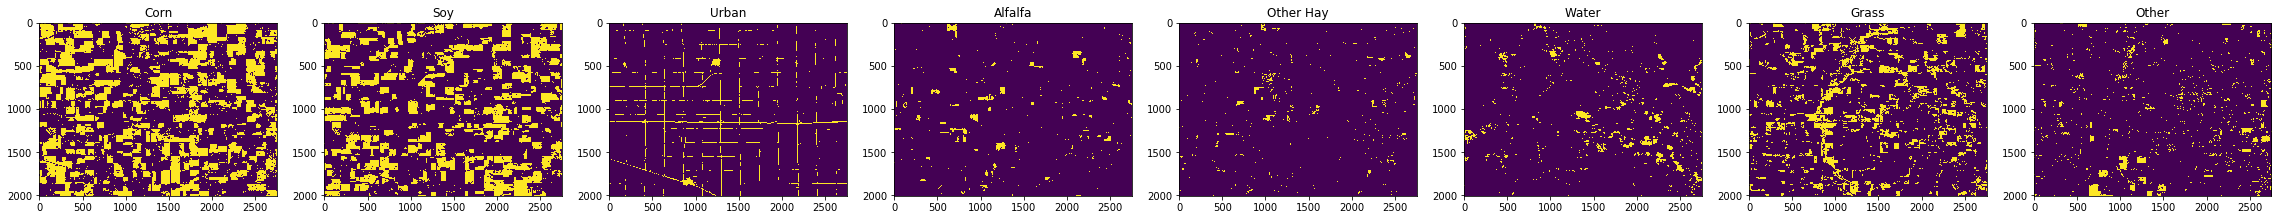

In [32]:
display_channels(new_data_y[1,:,:,:], new_data_y.shape[3], titles=titles)

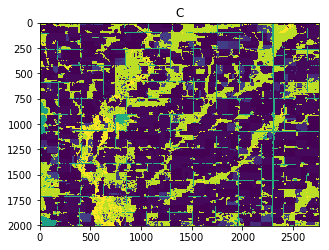

In [33]:
display_channels(data_y[0,:,:,:], data_y.shape[3], titles='Cropland')

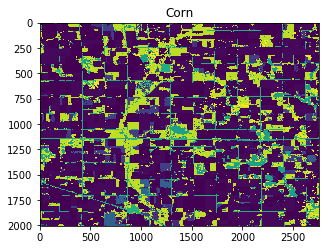

In [34]:
display_channels(data_y[1,:,:,:], data_y.shape[3], titles=titles)

In [35]:
#final piece of puts data_y to equal new data
data_y = new_data_y

## Moving data to only be 1 sample per site

Data originaly has 2 sites stacked  - the below creates 2 seperate classes you can run in Conv2d?

In [36]:
#seperates out the classes
data_x0 = data_x[0,:,:,:]
data_x1 = data_x[1,:,:,:]
data_y0 = data_y[0,:,:,:]
data_y1 = data_y[1,:,:,:]

In [37]:
data_x1.shape

(2004, 2753, 6)

## Preprocess datasets for training a Fully Connected Network (FCN)

**Normalize data**

In [41]:
def normalize_data(data):
    size = data.shape
    for i in range(size[-1]):
        mx = data.max()
        mn = data.min()
        
        data = (data-mn)/(mx-mn)
    return data

In [42]:
data_x = normalize_data(data_x)

### Resize the images into 1D arrays 

In [43]:
def reshape_data(data):
    size = data.shape
    new_size = []
    new_size.append(reduce(lambda x, y: x*y, size[:-1]))
    new_size.append(size[-1])
    new_size = tuple(new_size)
    return size, new_size

In [44]:
size_x, new_size_x = reshape_data(data_x)
size_y, new_size_y = reshape_data(data_y)

data_x_new = data_x.reshape(new_size_x)
data_y_new = data_y.reshape(new_size_y)

**Randomize the 1D datasets**

In [45]:
def randomize_datasets(data_x, data_y):
    t=data_x.shape[0]
    arr_t = np.arange(t)
    np.random.shuffle(arr_t)
    data_x = data_x[arr_t,:]
    data_y = data_y[arr_t,:]
    
    return data_x, data_y

**Training and validation sets for the 1D array**

In [48]:
def train_validation_split(x, y, val_size=20):
    t=x.shape[0]
    size = int(t*((100-val_size)/100))
    
    xt = x[:size,:]
    xv = x[size:,:]
    yt = y[:size,:]
    yv = y[size:,:]
    
    return xt, xv, yt, yv

## Define the Keras model

In [1]:
from keras.datasets import cifar10
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten, Conv3D, MaxPooling3D, Conv2DTranspose, Reshape
from keras.layers import UpSampling2D, BatchNormalization, Conv2D, MaxPooling2D
from keras.optimizers import SGD, RMSprop
from keras import backend as K
from keras.callbacks import Callback, ModelCheckpoint
from keras.models import model_from_json

Using TensorFlow backend.
/usr/local/lib/python3.5/dist-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.5/dist-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.5/dist-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.5/dist-packages/tensorflow/python/framework/dtypes.py:519: FutureWarn

In [52]:
# dim all the variables 
batch_size = bth
num_bands = bnd
num_classes = cls
epochs = epc
node = node
node2 = node2

# 2D CNN 

In [55]:
#adding an extra dimension to the individual layers

x_train3d = data_x0.reshape([-1,2004, 2753, 6])
y_train3d = data_y0.reshape([-1,2004, 2753, 8])

In [57]:
x_train3d_adj = x_train3d.copy()
y_train3d_adj = y_train3d.copy()

#Check whether 3rd dimension is odd. If so, trim the last result for x and y
if x_train3d.shape[2] % 2:
    x_train3d_adj =  x_train3d_adj[:,:,:-1,:]
    y_train3d_adj =  y_train3d_adj[:,:,:-1,:]

In [58]:
print (x_train3d.shape)
print (y_train3d.shape)
print (x_train3d_adj.shape)
print (y_train3d_adj.shape)

(1, 2004, 2753, 6)
(1, 2004, 2753, 8)
(1, 2004, 2752, 6)
(1, 2004, 2752, 8)


In [59]:
## Split the array in half along the y axis - https://docs.scipy.org/doc/numpy/reference/generated/numpy.split.html
xtest2 = np.array_split(x_train3d_adj, 2, axis=2)
ytest2 = np.array_split(y_train3d_adj, 2, axis=2)

In [60]:
xtest2 = np.asarray(xtest2)
ytest2 = np.asarray(ytest2)

In [61]:
np.array(xtest2).shape

(2, 1, 2004, 1376, 6)

In [62]:
#seperates out the classes
data_x20 = xtest2[0,:,:,:]
data_x21 = xtest2[1,:,:,:]
data_y20 = ytest2[0,:,:,:]
data_y21 = ytest2[1,:,:,:]

In [63]:
print (np.array(data_x20).shape)

(1, 2004, 1376, 6)


In [68]:
#standard no split model size
#input_shape=([2004, 2752, 6])

#model shape when split in half along the y axis
input_shape=([2004, 1376, 6])

#padding="same" / "valid"

model = Sequential()
model.add(Conv2D(32, (3, 3), padding="same", activation="relu",strides=(1, 1),input_shape=input_shape))
model.add(MaxPooling2D(pool_size=(2, 2),strides=(2, 2)))
model.add(Dropout(0.25))
model.add(Conv2D(64, (3, 3), padding="same", activation="relu",strides=(1, 1)))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(BatchNormalization())
model.add(Dropout(0.25))
model.add(Conv2D(128, (3, 3), padding="same", activation="relu",strides=(1, 1)))
#Upsampling - get the dataset back into the original format
model.add(UpSampling2D(size=(2,2),interpolation='nearest'))
model.add(UpSampling2D(size=(2,2),interpolation='nearest'))
#new - had the dense layer in there before
model.add(Conv2D(8, (3, 3), padding="same", activation="relu",strides=(1, 1)))
model.add(Activation("softmax"))
#model.add(Conv2D(1, (3, 3), padding="same", activation="relu",strides=(1, 1)))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 2004, 1376, 32)    1760      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 1002, 688, 32)     0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 1002, 688, 32)     0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 1002, 688, 64)     18496     
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 501, 344, 64)      0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 501, 344, 64)      256       
_________________________________________________________________
dropout_4 (Dropout)          (None, 501, 344, 64)      0         
__________

In [69]:
sgd = SGD(lr=0.000001, decay=1e-4, momentum=0.9, nesterov=True)

model.compile(loss='categorical_crossentropy',
            #optimizer='sgd',
            optimizer='adam',
            metrics=['accuracy'])

In [70]:
# To saves the model weights after each epoch if the validation loss decreased
checkpointer = ModelCheckpoint(filepath="{0}_weights.hdf5".format('FCN'), verbose=1, save_best_only=True)

In [71]:
#adding in validation
history = model.fit(np.array(data_x20), np.array(data_y20),
          batch_size=1,
          epochs=4000,
          verbose=2,
          validation_data=(data_x21, data_y21), callbacks=[checkpointer])

W0831 02:21:48.298513 139965462013696 deprecation.py:323] From /usr/local/lib/python3.5/dist-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Train on 1 samples, validate on 1 samples
Epoch 1/4000
 - 9s - loss: 2.2230 - acc: 0.0761 - val_loss: 1.8877 - val_acc: 0.3236

Epoch 00001: val_loss improved from inf to 1.88771, saving model to FCN_weights.hdf5
Epoch 2/4000
 - 1s - loss: 1.9779 - acc: 0.2665 - val_loss: 1.8360 - val_acc: 0.3230

Epoch 00002: val_loss improved from 1.88771 to 1.83597, saving model to FCN_weights.hdf5
Epoch 3/4000
 - 1s - loss: 1.8008 - acc: 0.3813 - val_loss: 1.7722 - val_acc: 0.3514

Epoch 00003: val_loss improved from 1.83597 to 1.77216, saving model to FCN_weights.hdf5
Epoch 4/4000
 - 1s - loss: 1.6789 - acc: 0.3953 - val_loss: 1.8074 - val_acc: 0.3965

Epoch 00004: val_loss did not improve from 1.77216
Epoch 5/4000
 - 1s - loss: 1.6066 - acc: 0.4245 - val_loss: 1.8301 - val_acc: 0.3649

Epoch 00005: val_loss did not improve from 1.77216
Epoch 6/4000
 - 1s - loss: 1.5492 - acc: 0.4513 - val_loss: 1.8318 - val_acc: 0.3571

Epoch 00006: val_loss did not improve from 1.77216
Epoch 7/4000
 - 1s - loss:

**Evaluate model**

In [73]:
score = model.evaluate(data_x20, data_y20, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.5806262493133545
Test accuracy: 0.799236536026001


In [74]:
# serialize model to JSON
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("model.h5")

# Model analysis Graphs

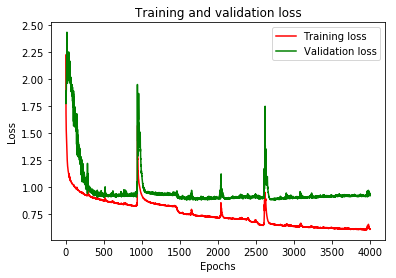

In [78]:
#Plotting training and validation loss

loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, color='red', label='Training loss')
plt.plot(epochs, val_loss, color='green', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

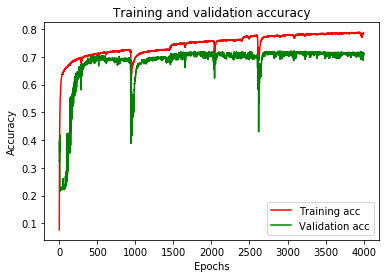

In [81]:
acc = history.history['acc']
val_acc = history.history['val_acc']
#plt.ylim(.6,.75)
plt.plot(epochs, acc, color='red', label='Training acc')
plt.plot(epochs, val_acc, color='green', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Confusion Matrix

In [82]:
confx1 = data_x20.transpose(0,3,1,2).reshape(8,-1)
confx2 = data_x21.transpose(0,3,1,2).reshape(8,-1)
confy1 = data_y20.transpose(0,3,1,2).reshape(8,-1)
confy2 = data_y21.transpose(0,3,1,2).reshape(8,-1)


In [83]:
# # taken from https://www.kaggle.com/amarjeet007/visualize-cnn-with-keras
# from sklearn.metrics import confusion_matrix
# Y_prediction = model.predict(confx2)
# # Convert predictions classes to one hot vectors 
# Y_pred_classes = np.argmax(confy1,axis = 1) 
# # Convert validation observations to one hot vectors
# Y_true = np.argmax(confy2,axis = 1) 
# # compute the confusion matrix
# confusion_mtx = confusion_matrix(Y_true, Y_pred_classes) 

# Run model on new site

In [86]:
#changed the num_classes from 4 to 6

from keras.models import model_from_json

#remember to check the input shape of your new layers
#input_shape=([2004, 2752, 6])

#model shape when split in half along the y axis
input_shape=([2004, 1376, 6])

model = Sequential()
model.add(Conv2D(32, (3, 3), padding="same", activation="relu",strides=(1, 1),input_shape=input_shape))
model.add(MaxPooling2D(pool_size=(2, 2),strides=(2, 2)))
model.add(Dropout(0.25))
model.add(Conv2D(64, (3, 3), padding="same", activation="relu",strides=(1, 1)))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(BatchNormalization())
model.add(Dropout(0.25))
model.add(Conv2D(128, (3, 3), padding="same", activation="relu",strides=(1, 1)))
#Upsampling - get the dataset back into the original format
model.add(UpSampling2D(size=(2,2),interpolation='nearest'))
model.add(UpSampling2D(size=(2,2),interpolation='nearest'))
#new - had the dense layer in there before
model.add(Conv2D(8, (3, 3), padding="same", activation="relu",strides=(1, 1)))

# load json and create model
json_file = open('model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights("model.h5")
print("Loaded model from disk")

Loaded model from disk


In [87]:
sgd = SGD(lr=0.000001, decay=1e-4, momentum=0.9, nesterov=True)

model.compile(loss='categorical_crossentropy',
            #optimizer='sgd',
            optimizer='adam',
            metrics=['accuracy'])

## Test Location

Test the FCN on the central region of South Dakota

In [88]:
# Central position of (AOIs) - Dell Rapids - South Dakota
point = point2

In [89]:
# buffer set to 10k - usually set to 10k - much larger area used
sentinel = ee_datasets(point = point, buffer = 10000 , startDate = startDate, stopDate = stopDate, scale = scale, collection = 'Sentinel2')
dataset_x = sentinel.read_datasets()
cropland = ee_datasets(point = point, buffer = 10000 , startDate = startDateCrop, stopDate = stopDateCrop, scale = scale, collection = 'CroplandDataLayers')
dataset_y = cropland.read_datasets()

We select the NIR, NDVI, NDWI channels

In [90]:
#below edited from data_x = dataset_x[:,:,3:] - you need the 3 when you only run on 3 bands
data_x2 = dataset_x
data_y2 = dataset_y

Sentinel 2 composite

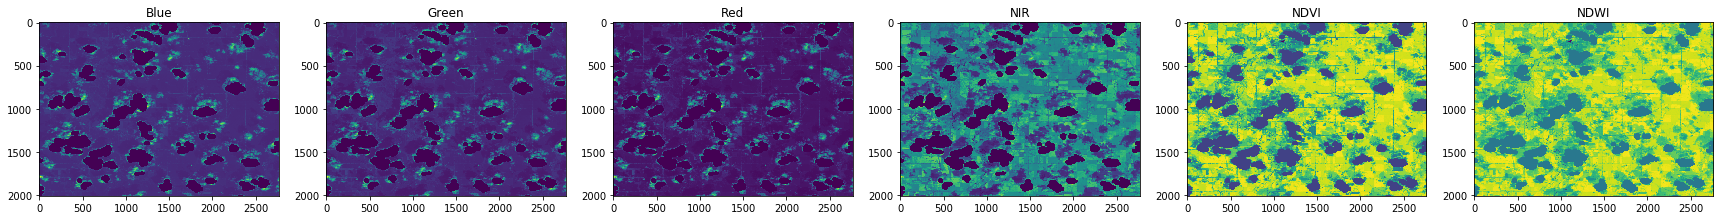

In [91]:
display_channels(data_x2, data_x2.shape[2], titles=titlesx)

Ground truth land cover classification

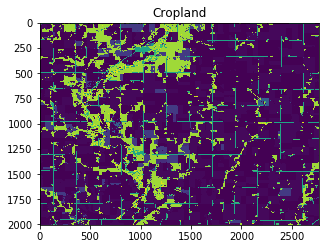

In [92]:
display_channels(data_y2, data_y2.shape[2], titles=['Cropland'])

**Preprocess class labels**

In [93]:
data_y2.shape

(2004, 2765, 1)

In [94]:
# replacing class labels again - now we have a 3D array so had to remove :, from the data_y 
new_data_y = np.copy(data_y2[:,:,0])
new_data_y = replace_values(new_data_y, class_labels_1, 1000.)
new_data_y = replace_values(new_data_y, class_labels_2, 2000.)
new_data_y = replace_values(new_data_y, class_labels_3, 3000.)
new_data_y = replace_values(new_data_y, class_labels_4, 4000.)
new_data_y = replace_values(new_data_y, class_labels_5, 5000.)
new_data_y = replace_values(new_data_y, class_labels_6, 6000.)
new_data_y = replace_values(new_data_y, class_labels_7, 7000.)  
new_data_y = replace_values(new_data_y, class_labels_8, 8000.)

#Divide by 1000 and subtract 1 to get results 0 to 7
new_data_y = np.divide(new_data_y, 1000.) -1
# Convert 1-dimensional class arrays to 4-dimensional class matrices
from keras.utils import np_utils
new_data_y = np_utils.to_categorical(new_data_y, cls)

In [95]:
#puts the new_data into 8 categories
new_data_y.shape

(2004, 2765, 8)

## Split Data

In [96]:
new_data_y.shape

(2004, 2765, 8)

In [97]:
x_pred_train3d = data_x2.reshape([-1,2004, 2765, 6])
y_pred_train3d = new_data_y.reshape([-1,2004, 2765, 8])

In [98]:
x_train3d_adj_pred = x_pred_train3d.copy()
y_train3d_adj_pred = y_pred_train3d.copy()

#Check whether 3rd dimension is odd. If so, trim the last result for x and y
if x_train3d.shape[2] % 2:
    x_train3d_adj_pred =  x_pred_train3d[:,:,:-13,:]
    y_train3d_adj_pred =  y_pred_train3d[:,:,:-13,:]

In [99]:
print (x_pred_train3d.shape)
print (y_pred_train3d.shape)
print (x_train3d_adj_pred.shape)
print (y_train3d_adj_pred.shape)

(1, 2004, 2765, 6)
(1, 2004, 2765, 8)
(1, 2004, 2752, 6)
(1, 2004, 2752, 8)


In [100]:
## Split the array in half along the y axis - https://docs.scipy.org/doc/numpy/reference/generated/numpy.split.html
xtest2 = np.array_split(x_train3d_adj_pred, 2, axis=2)
ytest2 = np.array_split(y_train3d_adj_pred, 2, axis=2)
#ytest2 = np.split(y_train3d_adj,1)

In [101]:
xtest2 = np.asarray(xtest2)
ytest2 = np.asarray(ytest2)

In [102]:
np.array(xtest2).shape

(2, 1, 2004, 1376, 6)

In [103]:
#seperates out the classes
data_x20 = xtest2[0,:,:,:]
data_x21 = xtest2[1,:,:,:]
data_y20 = ytest2[0,:,:,:]
data_y21 = ytest2[1,:,:,:]

In [104]:
print (np.array(data_x20).shape)
#print (xtrain2.shape)
#print (ytest2.shape)
#print (ytrain2.shape)

(1, 2004, 1376, 6)


**Preprocess input dataset**

In [105]:
def normalize_data(data):
    size = data.shape
    for i in range(size[-1]):
        mx = data.max()
        mn = data.min()
        
        data = (data-mn)/(mx-mn)
    return data

In [106]:
# Normalize
data_x_norm = normalize_data(data_x)
# Resize
size_x, new_size_x = reshape_data(data_x_norm)

x_input = data_x_norm.reshape(new_size_x)

## Data reformattting

In [107]:
data_x20.shape

(1, 2004, 1376, 6)

**Compute the prediction**

In [127]:
y_output = model.predict(data_x21, batch_size=batch_size, verbose=1)

1/1 [==============================] - 0s 459ms/step


**Resize the output**

In [130]:
data_y_output = data_y20.reshape((2004, 1376, 8))
#data_y_output = y_output.reshape((size_x[0], size_x[1],cls))

In [131]:
data_y_output_pred = y_output.reshape((2004, 1376, 8))


**Display the output**

In [132]:
#display_channels(y_output, y_output.shape[2], titles=titles)

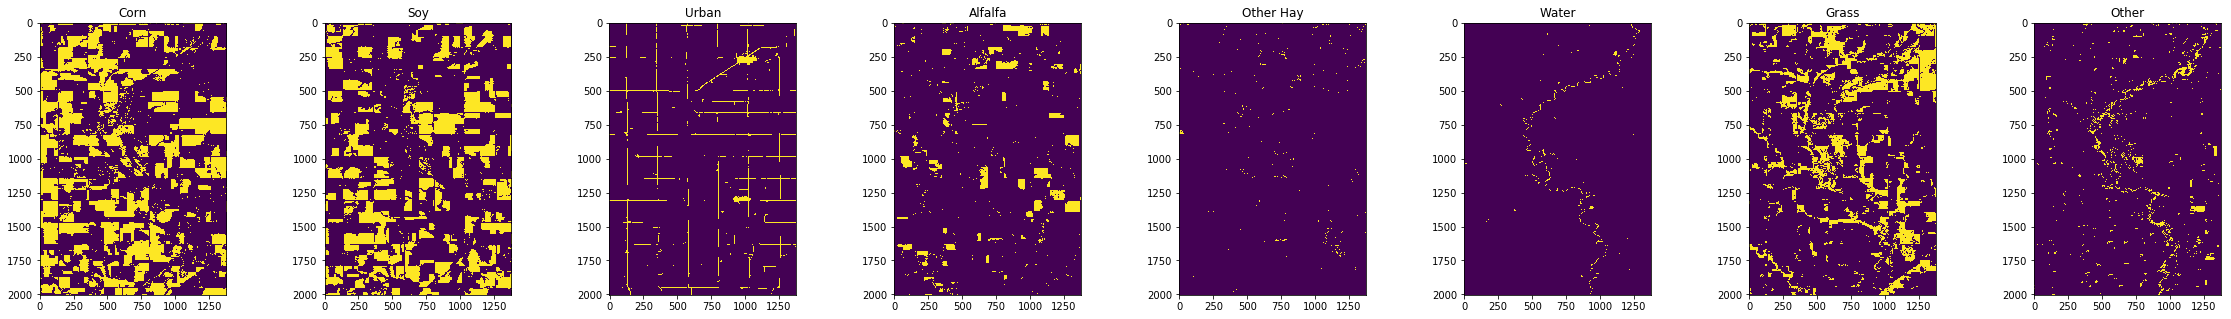

In [133]:
display_channels(data_y_output, data_y_output.shape[2], titles=titles)

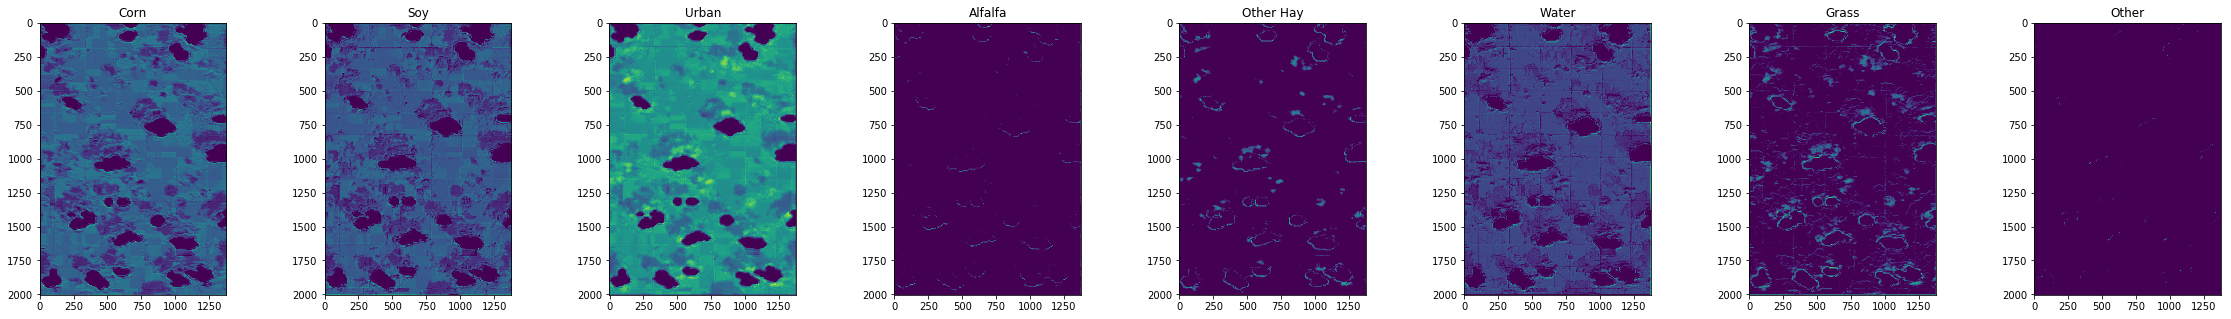

In [134]:
#original
display_channels(data_y_output_pred, data_y_output_pred.shape[2], titles=titles)

We binarize the output taking the highest pixel value

In [135]:
# Binarize the output
def max_pixels(x):
    x_new = x*0
    max_val = np.amax(x, axis=2)
    size = x.shape
    for i in range(size[-1]):
        ima = x[:,:,i]*0
        ima[np.where(x[:,:,i] == max_val)] = 1
        x_new[:,:,i]= ima

    return x_new

In [136]:
data_y_output_max = max_pixels(data_y_output_pred)

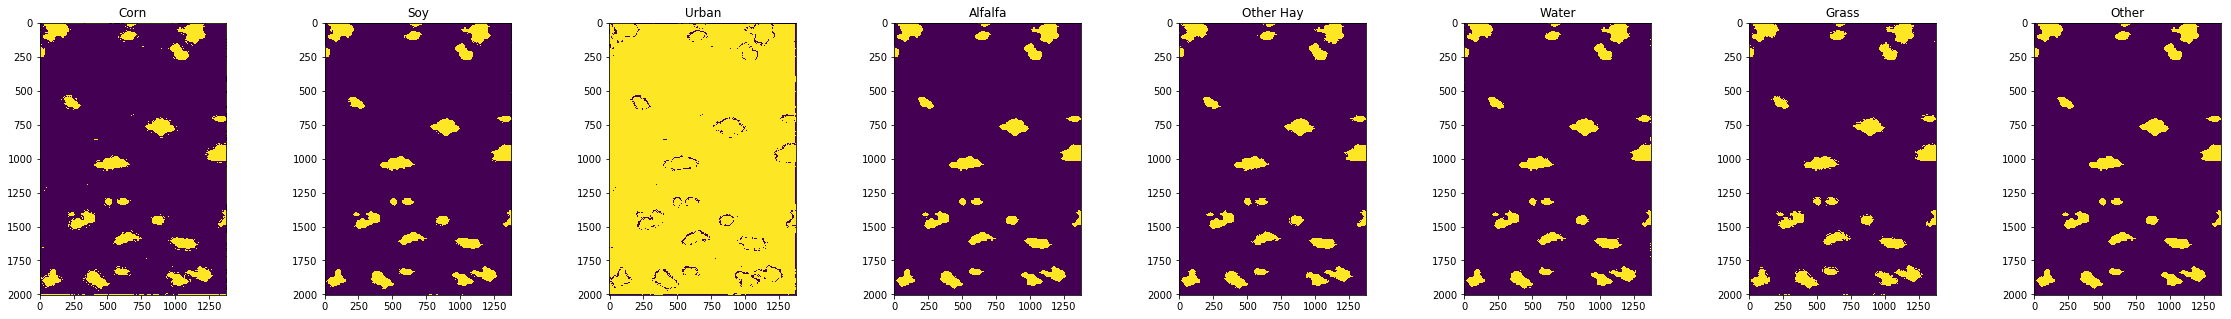

In [137]:
display_channels(data_y_output_max, data_y_output_max.shape[2], titles=titles)